## Imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import collections
import scipy
import operator
from functools import reduce
import community
from networkx.algorithms.community import greedy_modularity_communities
import seaborn as sns
sns.set(rc={'figure.figsize':(16,9)})
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Originally, the data was of the form **(E =  67,663 ; N = 3,321)** :

#### route.dat
This OpenFlights/Airline Route Mapper Route Database contains 67,663 routes (EDGES) between 3,321 airports (NODES) on 548 airlines spanning the globe.

- **Airline**	2-letter (IATA) or 3-letter (ICAO) code of the airline.
- **Airline ID**	Unique OpenFlights identifier for airline (see Airline).
- **Source airport**	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
- **Source airport ID**	Unique OpenFlights identifier for source airport (see Airport)
- **Destination airport**	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
- **Destination airport ID**	Unique OpenFlights identifier for destination airport (see Airport)
- **Codeshare**	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
- **Stops**	Number of stops on this flight ("0" for direct)
-  **Equipment**	3-letter codes for plane type(s) generally used on this flight, separated by spaces

The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.

Notes:
Routes are directional: if an airline operates services from A to B and from B to A, both A-B and B-A are listed separately.
Routes where one carrier operates both its own and codeshare flights are listed only once.


#### airport.dat
As of January 2017, the OpenFlights Airports Database contains over **10,000 airports, train stations and ferry terminals spanning the globe, as shown in the map above. Each entry contains the following information:

- **Airport ID**	Unique OpenFlights identifier for this airport.
- **Name**	Name of airport. May or may not contain the City name.
- **City**	Main city served by airport. May be spelled differently from Name.
- **Country**	Country or territory where airport is located. See countries.dat to cross-reference to ISO 3166-1 codes.
- **IATA**	3-letter IATA code. Null if not assigned/unknown.
- **ICAO**	4-letter ICAO code. Null if not assigned.
- **Latitude**	Decimal degrees, usually to six significant digits. Negative is South, positive is North.
- **Longitude**	Decimal degrees, usually to six significant digits. Negative is West, positive is East.
- **Altitude**	In feet.
- **Timezone**	Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.
- **DST**	Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time
- **Tz** database time zone	Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".
- **Type**	Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.
- **Source**	In airports.csv, only source=OurAirports is included.
The data is UTF-8 encoded.

Note: Rules for daylight savings time change from year to year and from country to country. The current data is an approximation for 2009, built on a country level. Most airports in DST-less regions in countries that generally observe DST (eg. AL, HI in the USA, NT, QL in Australia, parts of Canada) are marked incorrectly.

## Loading the datasets

In [2]:
routes = pd.read_csv('routes.dat', header=None)
routes.columns = ['Airline',
                'Airline ID',
                'Source airport',
                'Source airport ID',
                'Destination airport',
                'Destination airport ID',
                'Codeshare',
                'Stops',
                'Equipment']

airports = pd.read_csv('airports.dat', header=None, index_col=4, na_values='\\N')
airports.columns = ['Airport ID',
                    'Name',
                    'City',
                    'Country',
                    'ICAO',
                    'Latitude',
                    'Longitude',
                    'Altitude',
                    'Timezone',
                    'DST',
                    'TZ',
                    'Type',
                    'Source']

In [3]:
routes.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [4]:
airports.head()

,Airport ID,Name,City,Country,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TZ,Type,Source
4,,,,,,,,,,,,,
GKA,1,Goroka Airport,Goroka,Papua New Guinea,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
MAG,2,Madang Airport,Madang,Papua New Guinea,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
HGU,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
LAE,4,Nadzab Airport,Nadzab,Papua New Guinea,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
POM,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports


### Cleaning

In [5]:
#Find common airport between both datasets airport.dat and route.dat
airports_route = list(set(set(routes['Source airport']) | set(routes['Destination airport'])))
airports_air = list(airports.index)
nodes = list(set(airports_air) & set(airports_route))

#We keep the edges that start and arrive at know airports
routes_clean = routes[(routes['Source airport'].isin(nodes)) & (routes['Destination airport'].isin(nodes))]
airports_clean = airports[airports.index.isin(nodes)]

In [6]:
#We add the lat.long for starting and arriving airports (4 columns)
routes_clean['Source latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Latitude.values.item(0), axis = 1)
routes_clean['Source longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Longitude.values.item(0), axis = 1)
routes_clean['Destination latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Latitude.values.item(0), axis = 1)
routes_clean['Destination longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Longitude.values.item(0), axis = 1)

In [7]:
#add the distance between the source and destination in km
routes_clean['Distance'] = routes_clean.apply(lambda row : geodesic((row['Source latitude'], row['Source longitude']), (row['Destination latitude'], row['Destination longitude'])).kilometers, axis = 1)

In [8]:
routes_clean.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment,Source latitude,Source longitude,Destination latitude,Destination longitude,Distance
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2,43.449902,39.956600,55.606201,49.278702,1507.989717
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2,46.283298,48.006302,55.606201,49.278702,1040.943207
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2,46.283298,48.006302,44.225101,43.081902,449.036664
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2,55.305801,61.503300,55.606201,49.278702,773.126239
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2,55.305801,61.503300,55.012600,82.650703,1343.161122


**Save the clean data**

In [9]:
routes_clean.to_csv('routes_clean.csv', index=False)
airports_clean.to_csv('airports_clean.csv')

## Data Exploration

**Load clean data**

In [10]:
routes = pd.read_csv('routes_clean.csv', low_memory=False)

In [11]:
airports = pd.read_csv('airports_clean.csv', index_col=0)

**Create graph using networkx from a list of edges**

In [12]:
#we can add attributes here
G = nx.from_pandas_edgelist(routes, 'Source airport', 'Destination airport', ['Distance'])

**Statistics to explore**
- average degree
- connected components
- diameter
- centrality measures (computed from the shortest paths)
- graph density
- pagerank
- eigenvector centrality

### Degree ditribution

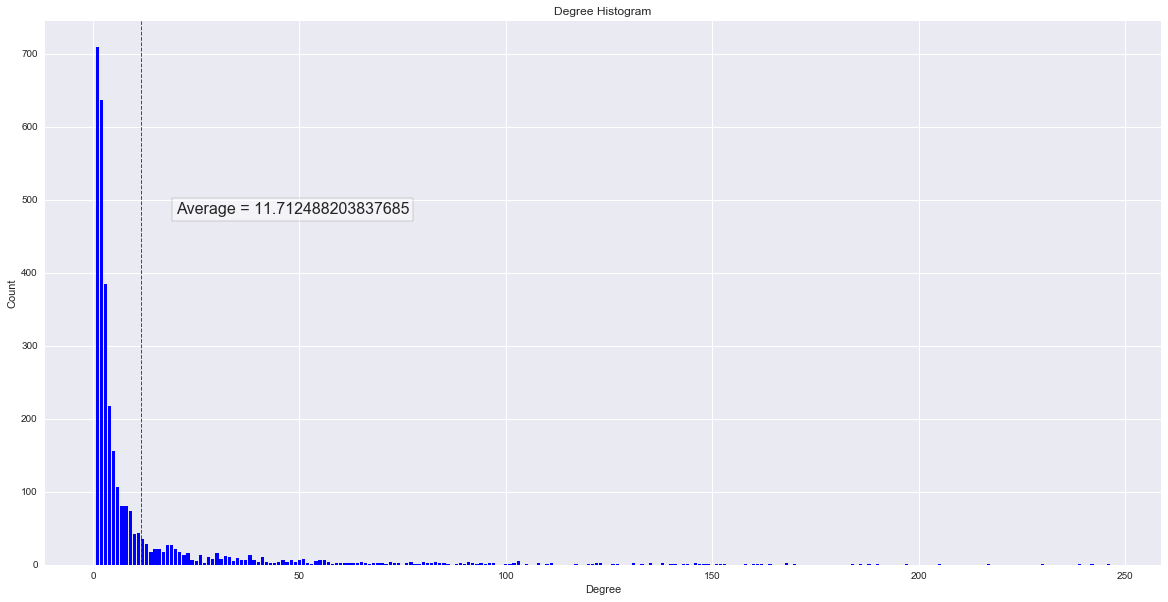

In [13]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize = (20,10))
plt.bar(deg, cnt, width=0.80, color='b')
mean = np.array(degree_sequence).mean()
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.text(20,480,'Average = {}'.format(mean),bbox=dict(facecolor='white', alpha=0.5), fontsize=16)
plt.show()


### Graph Connectivity

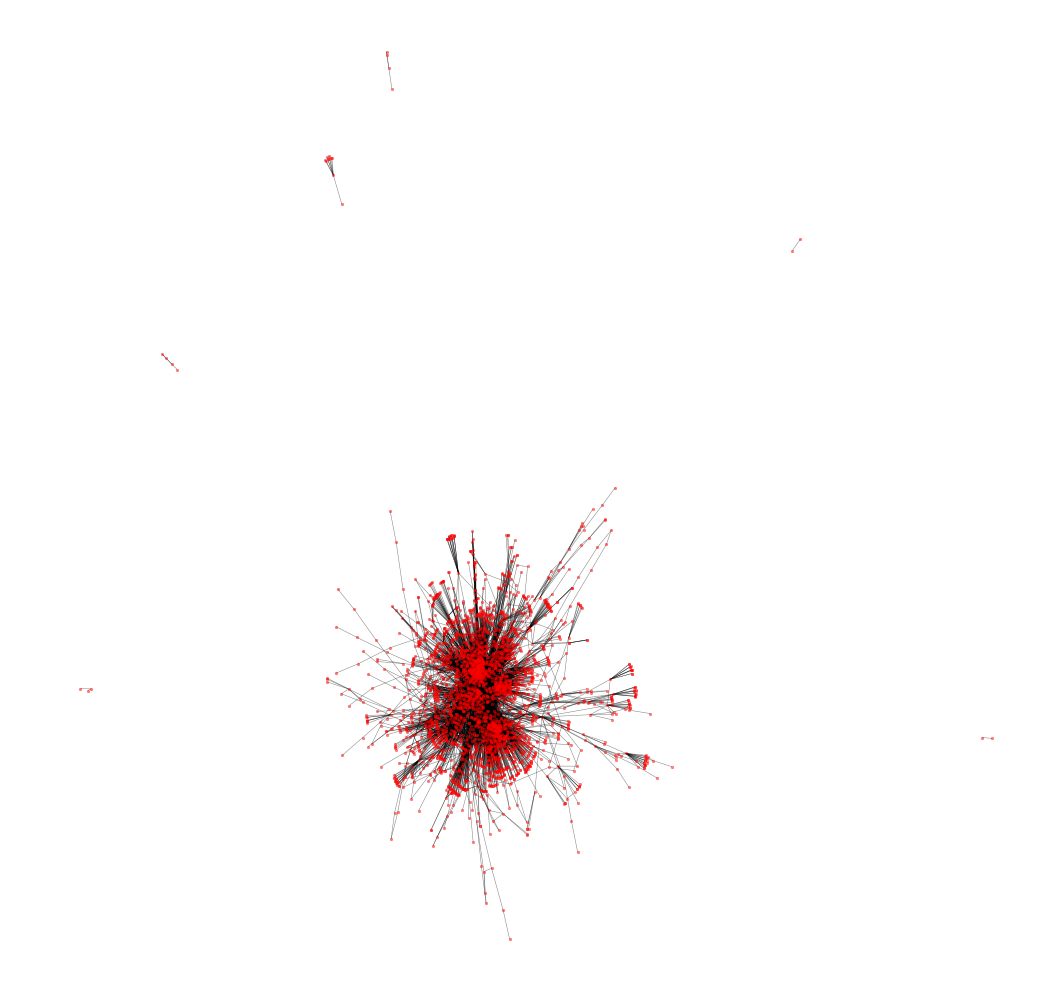

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(G, ax=ax, node_size=8, alpha=.5,
                 width=.5, with_labels=False)
ax.set_axis_off()

We can see that our graph is not connected. In fact, there are 7 components in total.

In [15]:
nx.number_connected_components(G)

7

We get the largest connected component for the continuation. It contains 3154 nodes.

In [16]:
largest_cc = max(nx.connected_component_subgraphs(G), key=len)
len(largest_cc.nodes())

3154

### Largest component diameter 
The diameter of the graph is the length of the longest shortest path between any pair of nodes.

In [17]:
nx.diameter(largest_cc)

12

### Clutering coefficient

**The neighborhood of a node u, is the set of nodes that are connected to u**. The clustetring coefficient of a node  **u**  is the fraction of the node’s neighbors that are connected. Finally, we pbtain the average clustering coefficient by averaging this value over all nodes of the graph.

In [18]:
nx.average_clustering(largest_cc)

0.49144436995862

### Graph Density

In [19]:
nx.density(largest_cc)

0.003739330098198392

### Centrality

In [20]:
def get_NameCity(ID):
    row = airports.loc[ID]
    return row['Name'], row['City']

In [21]:
def plot_dict(dict_, k, name):
    

    def print_rank(l):
        for k in range(len(l)):

            a,b = get_NameCity(l[k])
            print('{}. {}, {}'.format(k+1,a,b))
            
    
    airports, values = list(dict_.keys()), list(dict_.values())
    sort_index = list(np.argsort(values))
    airports_s = np.array(airports)[sort_index][::-1] #k highest ranked
    values_s = np.array(values)[sort_index][::-1]

    sns.barplot(x=airports_s[:k], y=values_s[:k],palette="deep", label='small')
    
    print('- In means of {} : Top 15 respectively are : '.format(name,k))
    print_rank(airports_s[:k])
    return list(zip(airports_s, np.array(range(len(airports_s)))+1))


#### Betweenness centrality:

- In means of betweenness : Top 15 respectively are : 
1. Charles de Gaulle International Airport, Paris
2. Los Angeles International Airport, Los Angeles
3. Dubai International Airport, Dubai
4. Ted Stevens Anchorage International Airport, Anchorage
5. Frankfurt am Main International Airport, Frankfurt
6. Amsterdam Airport Schiphol, Amsterdam
7. Beijing Capital International Airport, Beijing
8. Chicago O'Hare International Airport, Chicago
9. Lester B. Pearson International Airport, Toronto
10. Atatürk International Airport, Istanbul
11. Guarulhos - Governador André Franco Montoro International Airport, Sao Paulo
12. London Heathrow Airport, London
13. Narita International Airport, Tokyo
14. Sydney Kingsford Smith International Airport, Sydney
15. Seattle Tacoma International Airport, Seattle


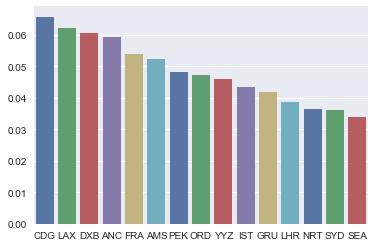

In [22]:
betweenness = nx.betweenness_centrality(largest_cc)
bet_sort = plot_dict(betweenness,15,'betweenness')


#### Eigenvalue centrality:

- In means of eigenvectors : Top 15 respectively are : 
1. Amsterdam Airport Schiphol, Amsterdam
2. Frankfurt am Main International Airport, Frankfurt
3. Charles de Gaulle International Airport, Paris
4. Munich International Airport, Munich
5. Leonardo da Vinci–Fiumicino Airport, Rome
6. London Heathrow Airport, London
7. Barcelona International Airport, Barcelona
8. Atatürk International Airport, Istanbul
9. Zürich Airport, Zurich
10. Adolfo Suárez Madrid–Barajas Airport, Madrid
11. Brussels Airport, Brussels
12. Dublin Airport, Dublin
13. Düsseldorf International Airport, Duesseldorf
14. London Gatwick Airport, London
15. Manchester Airport, Manchester


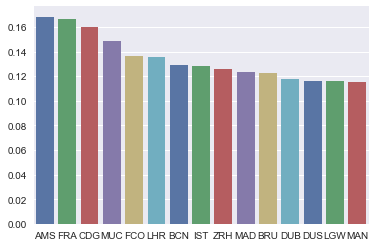

In [23]:
eigenve = nx.eigenvector_centrality(largest_cc)
eig_sort = plot_dict(eigenve, 15, 'eigenvectors')


### PageRank

PageRank is often compared to Katz centrality measure, and therefor can be compared to other centrality measure

- In means of pagerank : Top 15 respectively are : 
1. Hartsfield Jackson Atlanta International Airport, Atlanta
2. Chicago O'Hare International Airport, Chicago
3. Dallas Fort Worth International Airport, Dallas-Fort Worth
4. Atatürk International Airport, Istanbul
5. Denver International Airport, Denver
6. Charles de Gaulle International Airport, Paris
7. Domodedovo International Airport, Moscow
8. Amsterdam Airport Schiphol, Amsterdam
9. Frankfurt am Main International Airport, Frankfurt
10. Dubai International Airport, Dubai
11. Beijing Capital International Airport, Beijing
12. George Bush Intercontinental Houston Airport, Houston
13. Los Angeles International Airport, Los Angeles
14. Sydney Kingsford Smith International Airport, Sydney
15. Lester B. Pearson International Airport, Toronto


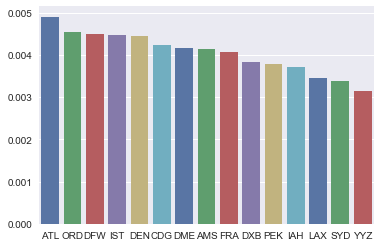

In [24]:
pagerank = nx.pagerank(largest_cc)
pr_sort = plot_dict(pagerank, 15, 'pagerank')


In [25]:
bt = pd.DataFrame(bet_sort, columns = ['Airport ID', 'Betweenness']) 
eg = pd.DataFrame(eig_sort, columns = ['Airport ID', 'EigenVectors']) 
pr = pd.DataFrame(pr_sort, columns = ['Airport ID', 'PageRank']) 

dfs = [bt, eg, pr]
df_final = reduce(lambda left,right: pd.merge(left,right,on='Airport ID'), dfs)

In [26]:
df_final['Average'] = (df_final['Betweenness']+df_final['EigenVectors']+df_final['PageRank'])/3
df_final.sort_values('Average',inplace=True)
df_final.reset_index(drop = True,inplace=True)
df_final['OverAll Rank'] = np.array(df_final.index)+1
df_final.set_index('Airport ID',inplace=True)
namecity = pd.Series(df_final.index).apply(lambda x : str('{}, {}'.format(get_NameCity(x)[0],get_NameCity(x)[1])))
df_final.reset_index(inplace=True)
df_final['Airport Name, City'] = namecity
df_final.set_index('Airport ID',inplace=True)
df_final.head(15)

,Betweenness,EigenVectors,PageRank,Average,OverAll Rank,"Airport Name, City"
Airport ID,,,,,,
CDG,1,3,6,3.333333,1,"Charles de Gaulle International Airport, Paris"
AMS,6,1,8,5.000000,2,"Amsterdam Airport Schiphol, Amsterdam"
FRA,5,2,9,5.333333,3,"Frankfurt am Main International Airport, Frank..."
IST,10,8,4,7.333333,4,"Atatürk International Airport, Istanbul"
DXB,3,20,10,11.000000,5,"Dubai International Airport, Dubai"
ORD,8,28,2,12.666667,6,"Chicago O'Hare International Airport, Chicago"
LHR,12,6,20,12.666667,7,"London Heathrow Airport, London"
YYZ,9,29,15,17.666667,8,"Lester B. Pearson International Airport, Toronto"
PEK,7,37,11,18.333333,9,"Beijing Capital International Airport, Beijing"


## World map

To create the map, we first retrieve the coordinates from the airports dataframe

In [27]:
pos = {airport: (v['Longitude'], v['Latitude'])
       for airport, v in
       airports.to_dict('index').items()}

Node size will be the degree of the nodes

In [28]:
deg = nx.degree(largest_cc)
sizes = [5 * deg[iata] for iata in largest_cc.nodes]

Display label only if degree is quite big

In [29]:
labels = {iata: iata if deg[iata] >= 200 else ''
          for iata in largest_cc.nodes}

In [30]:
def display_map(graph, node_color=None):
    # Map projection
    fig, ax = plt.subplots(
        1, 1, figsize=(36, 24),
        subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.coastlines()

    # Extent of continental US.
    #ax.set_extent([-128, -62, 20, 50])
    nx.draw_networkx(graph, ax=ax,
                     font_size=20,
                     alpha=.5,
                     width=.075,
                     node_size=sizes,
                     labels=labels,
                     pos=pos,
                     node_color=node_color)

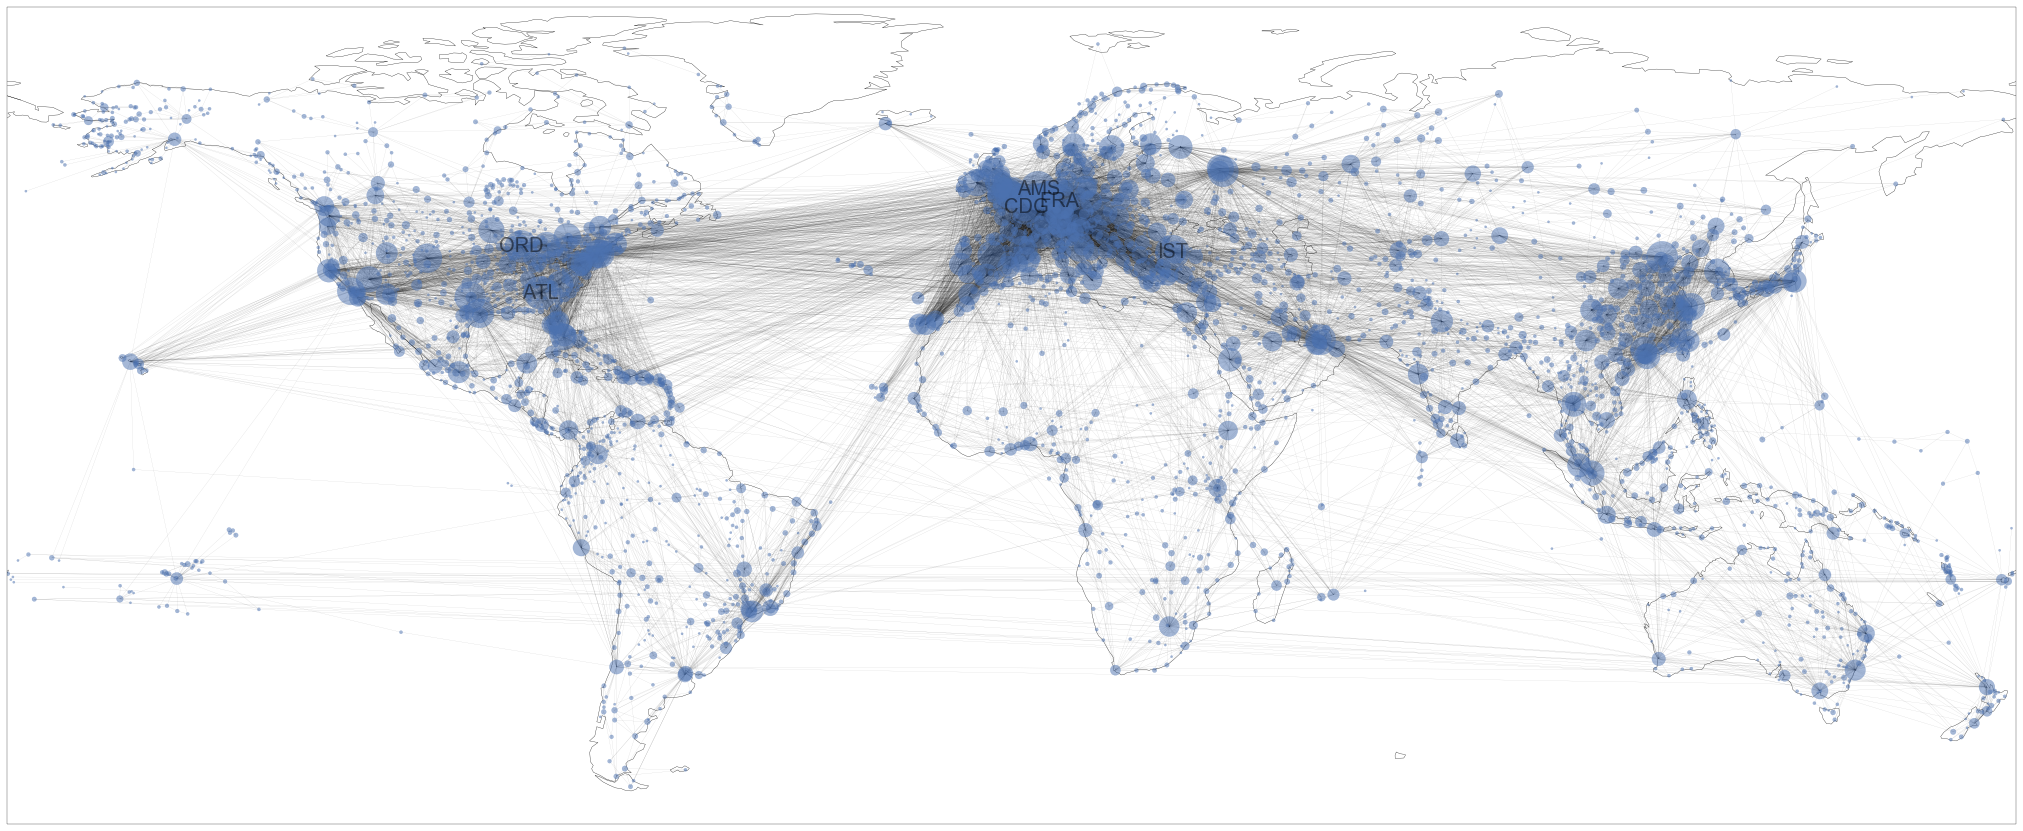

In [31]:
display_map(largest_cc)

## Flight distance

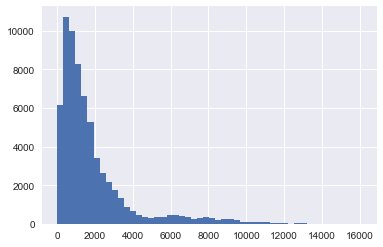

In [32]:
plt.hist(routes_clean['Distance'].values, bins = 50)
plt.show()

## Local/international flights

In [33]:
routes_clean['Source country'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Country.values.item(0), axis = 1)
routes_clean['Destination country'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Country.values.item(0), axis = 1)

In [34]:
routes_clean['International flight'] = routes_clean.apply(lambda row : not (row['Source country'] == row['Destination country']), axis = 1)

In [35]:
routes_clean['International flight'].value_counts()

True     34222
False    31845
Name: International flight, dtype: int64

In [36]:
collections.Counter(routes_clean['Source country']).most_common(10)

[('United States', 12999),
 ('China', 7995),
 ('United Kingdom', 2634),
 ('Spain', 2525),
 ('Germany', 2328),
 ('France', 1924),
 ('Canada', 1835),
 ('Russia', 1793),
 ('Italy', 1770),
 ('Brazil', 1385)]

In [37]:
collections.Counter(routes_clean['Destination country']).most_common(10)

[('United States', 12994),
 ('China', 7995),
 ('United Kingdom', 2608),
 ('Spain', 2527),
 ('Germany', 2312),
 ('France', 1920),
 ('Canada', 1844),
 ('Russia', 1800),
 ('Italy', 1773),
 ('Brazil', 1382)]

In [38]:
collections.Counter(routes_clean['Source airport']).most_common(10)

[('ATL', 915),
 ('ORD', 556),
 ('CDG', 523),
 ('LHR', 523),
 ('PEK', 520),
 ('LAX', 489),
 ('FRA', 489),
 ('DFW', 469),
 ('JFK', 454),
 ('AMS', 450)]

In [39]:
collections.Counter(routes_clean['Destination airport']).most_common(10)

[('ATL', 911),
 ('ORD', 548),
 ('LHR', 520),
 ('PEK', 519),
 ('CDG', 516),
 ('LAX', 497),
 ('FRA', 485),
 ('DFW', 467),
 ('JFK', 453),
 ('AMS', 446)]

In [40]:
routes_clean[['Source airport', 'Source airport ID', 'Source country']].groupby(['Source airport', 'Source country']).count().sort_values(by = ['Source airport ID'], ascending = False)

,,Source airport ID
Source airport,Source country,
ATL,United States,915
ORD,United States,556
LHR,United Kingdom,523
CDG,France,523
PEK,China,520
LAX,United States,489
FRA,Germany,489
DFW,United States,469
JFK,United States,454


## Laplacian / distance

In [41]:
laplacian = nx.laplacian_matrix(largest_cc).toarray()

In [42]:
laplacian

array([[18, -1,  0, ...,  0,  0,  0],
       [-1, 21, -1, ...,  0,  0,  0],
       [ 0, -1,  7, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  3, -1,  0],
       [ 0,  0,  0, ..., -1,  2,  0],
       [ 0,  0,  0, ...,  0,  0,  1]], dtype=int32)

In [43]:
e, U =  scipy.linalg.eigh(laplacian)

In [44]:
# Indice of the first non-zero eigenvalue
lambda_1_ind = 5

# Laplacian eigenmaps
coords = U[:, lambda_1_ind:lambda_1_ind+2]

def plot_signal(signal):
    """Display nodes of the graph in 2D
    together with the given signal"""
    
    nodes = nx.draw_networkx_nodes(largest_cc, dict(zip(largest_cc.nodes, coords)), node_size=30, node_color=signal)
    plt.xlabel('Value of $\lambda_1$')
    plt.ylabel('Value of $\lambda_2$')
    plt.colorbar(nodes)



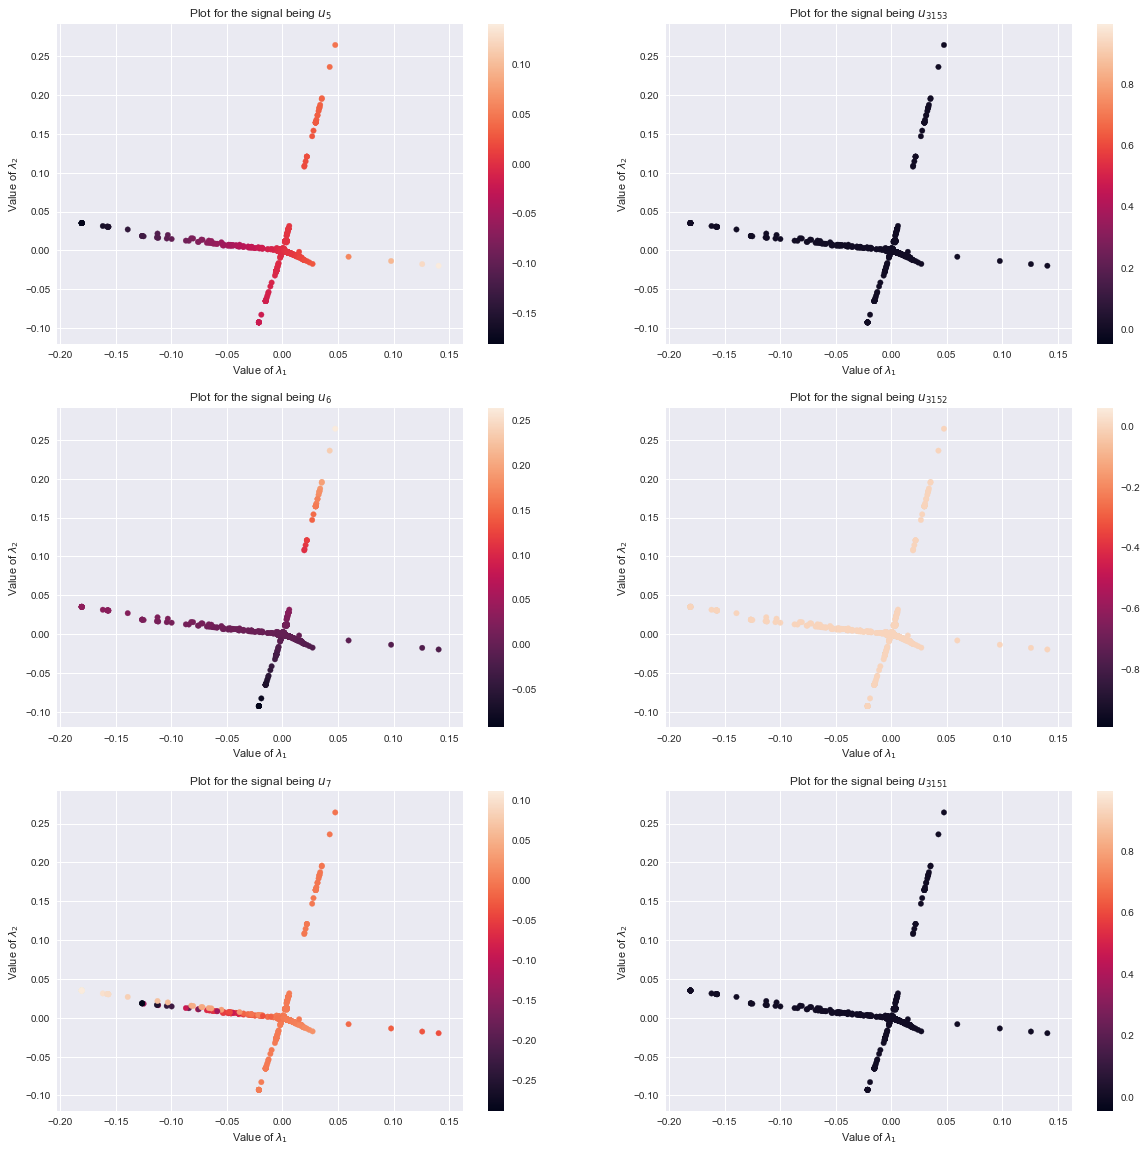

In [45]:
plt.figure(figsize=(20, 20))

# Plot the first 3 Fourier basis vectors
for i in range(3):
    plt.subplot(321 + 2*i)
    plot_signal(U[:, lambda_1_ind + i])
    plt.title('Plot for the signal being $u_{'+ str(lambda_1_ind + i)+'}$')

    # Plot the last 3 Fourier basis vectors
for i in range(3):
    plt.subplot(322 + 2*i)
    plot_signal(U[:, len(largest_cc) - (i + 1)])
    plt.title('Plot for the signal being $u_{'+ str(len(largest_cc) - (i + 1))+'}$')

plt.show()



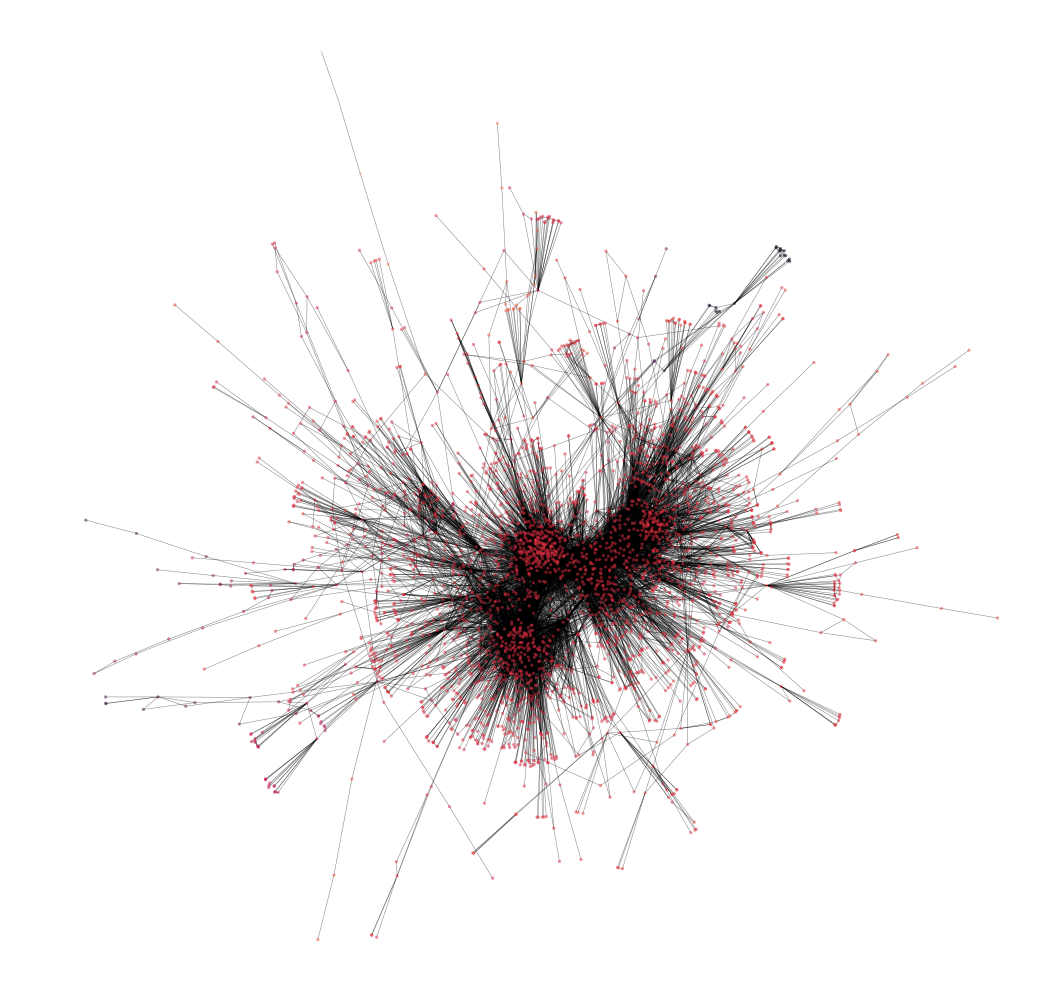

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw(largest_cc, node_color = U[:,5], ax=ax, node_size=8, alpha=.5,
                 width=.5, with_labels=False, )
ax.set_axis_off()

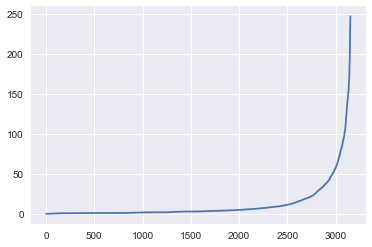

In [47]:
plt.plot(e, '+-')

In [48]:
def plot_community_distr(G):
    
    partition1 = nx.algorithms.community.greedy_modularity_communities(G)
    partition2 = community.best_partition(G)
    
    # Partition1
    mod_classes = np.arange(len(partition1))

    # Partition2
    c = collections.Counter(list(partition2.values()))
    k = c.keys()
    v = c.values()
    
    num_nodes = []
    for set_ in partition1:
        num_nodes.append(len(set_))
    
    plt.figure(figsize=(15,9))
    plt.scatter(mod_classes, num_nodes, label='Clauset-Newman-Moore greedy modularity maximization')
    plt.scatter(k, v, label='Louvain method')
    plt.axis([0, 41, 0, 950])
    plt.xlabel('Modularity class')
    plt.ylabel('Number of nodes')
    plt.xticks(mod_classes)
    plt.legend()
    plt.grid()

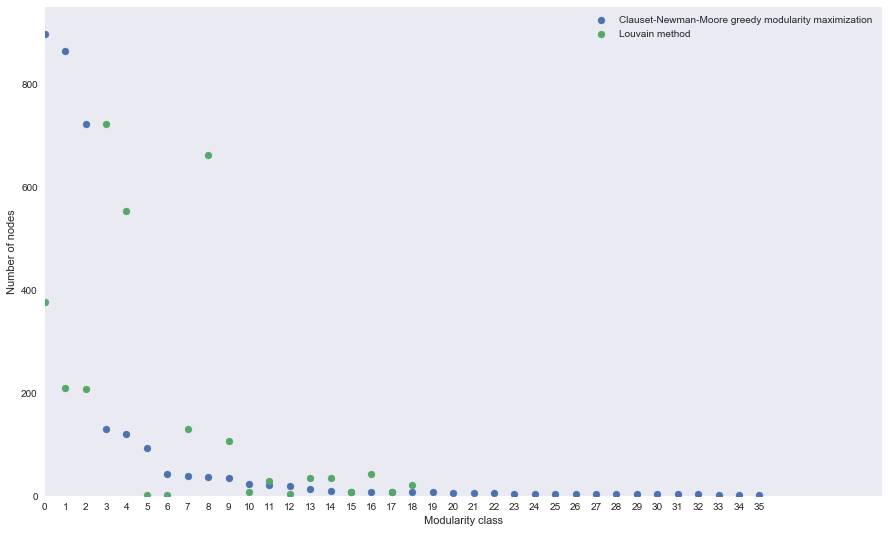

In [49]:
plot_community_distr(largest_cc)

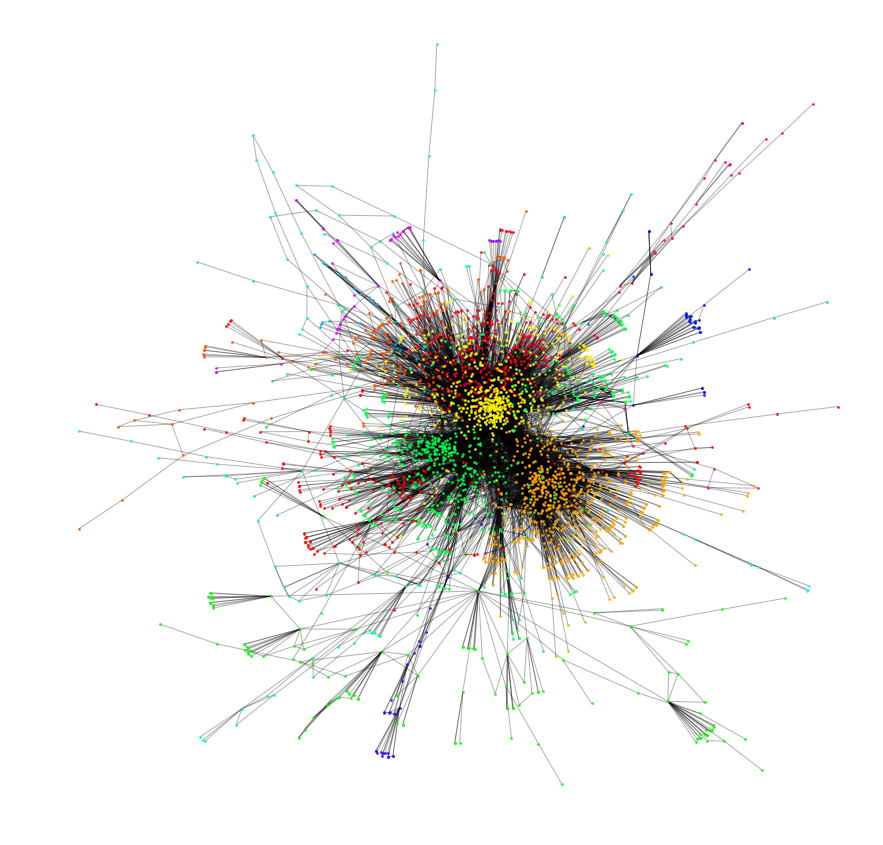

In [50]:
#first compute the best partition
partition = community.best_partition(largest_cc)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

#drawing
size = float(len(set(partition.values())))

cmap = plt.cm.get_cmap('hsv')
rgba = np.linspace(0.0, 1.0, num=size)

pos = nx.spring_layout(largest_cc)
count = 0
for com in set(partition.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(largest_cc, pos, list_nodes, ax=ax, node_size=5,
                                node_color=cmap(rgba[count-2]))


nx.draw_networkx_edges(largest_cc, pos, alpha=0.3)
ax.set_axis_off()

In [51]:
cluster = np.load('clustered.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'clustered.npy'